## Assignment Week 5 - Biswajit Sharma

Get the stemmed data using the same process you did in Week 3.

In [25]:
# import modules

import pandas as pd
import unicodedata
import sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# read the dataset into a dataframe
df = pd.read_csv("./datasets/labeledTrainData.tsv", sep="\t")

In [3]:
# convert reviews to lower case and store in a new column
df["cleaned_review"] = df["review"].str.lower()

In [4]:
# this function clean punctuation and symbols from input text
punctuation = dict.fromkeys(
[i for i in range(sys.maxunicode)
if unicodedata.category(chr(i)).startswith("P") or unicodedata.category(chr(i)).startswith("S")],
    None
 )
def remove_punctuation_symbols(text):
    return text.translate(punctuation)

In [5]:
# remove punctuation and symbols from reviews using the above function 
df["cleaned_review"] = df["cleaned_review"].apply(remove_punctuation_symbols)

In [6]:
# this function removes stopwords from input text
stop_words = stopwords.words("english")
def remove_stopwords(text):
    tokenized_words = word_tokenize(text)
    return " ".join([word for word in tokenized_words if word not in stop_words])

In [7]:
# remove stopwords from reviews using above function
df["cleaned_review"] = df["cleaned_review"].apply(remove_stopwords)

In [8]:
# this function perform stemming on the input text using NLTK PorterStemmer
def porter_stemmer(text):
    tokenized_words = word_tokenize(text)
    porter = PorterStemmer()
    return " ".join([porter.stem(words) for words in tokenized_words])

In [9]:
# apply stemming on reviews using above function
df["cleaned_review"] = df["cleaned_review"].apply(porter_stemmer)

In [10]:
# view few rows after the above text preparation
df.head()

,id,sentiment,review,cleaned_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothi hine entertain film ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film start manag nichola bell give welcom inve...
3,3630_4,0,It must be assumed that those who praised this...,must assum prais film greatest film opera ever...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbl trashi wondrous unpretenti 80 exploit ...


Split this into a training and test set.

In [11]:
#features and target names
features_columns = "cleaned_review"
target_column = "sentiment"

In [12]:
# using sklearn's train_test_split method to split the dataset
features_train, features_test, target_train, target_test = train_test_split(
    df[features_columns], df[target_column], test_size=0.2, random_state=0
)

Fit and apply the tf-idf vectorization to the training set.

In [13]:
# generate term frequency-inverse document frequency (tf-idf) matrix using TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(features_train)

TfidfVectorizer()

In [14]:
# apply Tf-Idf to train set
tfidf_train_feature_matrix = tfidf.transform(features_train)

In [15]:
tfidf_train_feature_matrix

<20000x81126 sparse matrix of type '<class 'numpy.float64'>'
	with 1956541 stored elements in Compressed Sparse Row format>

Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

In [16]:
# apply Tf-Idf to test set
tfidf_test_feature_matrix = tfidf.transform(features_test)

Train a logistic regression using the training data.

In [17]:
logistic = LogisticRegression(random_state=0)

In [18]:
logistic.fit(tfidf_train_feature_matrix, target_train)

LogisticRegression(random_state=0)

Find the model accuracy on test set.

In [19]:
predicted_target_train = logistic.predict(tfidf_train_feature_matrix)

In [20]:
predicted_target_test = logistic.predict(tfidf_test_feature_matrix)

In [21]:
accuracy_score(target_test, predicted_target_test)

0.8926

Create a confusion matrix for the test set predictions.

In [22]:
matrix = confusion_matrix(target_test, predicted_target_test)

In [23]:
conf_df = pd.DataFrame(matrix, index=["positive", "negative"], columns=["positive", "negative"])

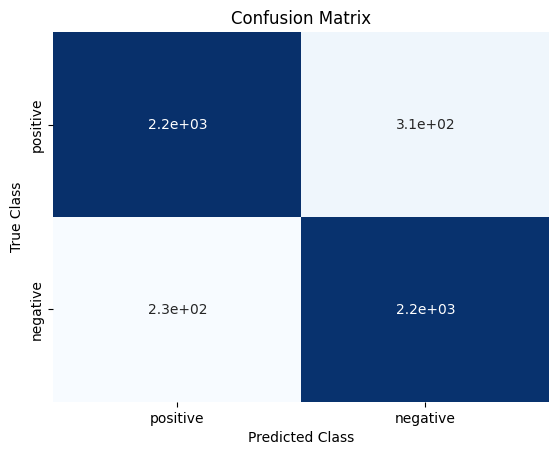

In [24]:
sns.heatmap(conf_df, cbar=False, cmap="Blues", annot=True)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Get the precision, recall, and F1-score for the test set predictions.

In [26]:
print(f"Precision: {precision_score(target_test, predicted_target_test)}")
print(f"Recall: {recall_score(target_test, predicted_target_test)}")
print(f"F1-Score: {f1_score(target_test, predicted_target_test)}")

Precision: 0.8783089687870407
Recall: 0.9066068515497553
F1-Score: 0.8922335942203492


In [28]:
#get target probabilities
target_probabilities = logistic.predict_proba(tfidf_test_feature_matrix)[:,1]

In [29]:
#calculate true and false positive rates for test set
fasle_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)


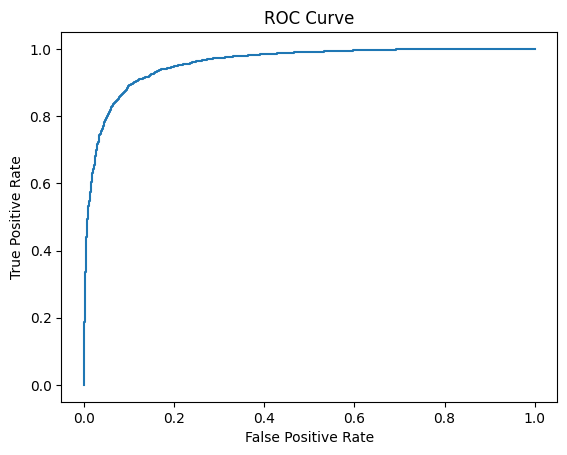

In [30]:
#plotting the ROC curve
plt.plot(fasle_positive_rate, true_positive_rate)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
# dimensions of the generated bag-of-words matrix
bag_of_words.shape

In [ ]:
# dimensions of the dataframe
df.shape

we see that the number of rows of the bag-of-words matrix is same as the number of rows in the original dataframe i.e $25000$

Create a term frequency-inverse document frequency (tf-idf) matrix from your stemmed text, for your movie reviews (see section 6.9 in the Machine Learning with Python Cookbook). Display the dimensions of your tf-idf matrix. These dimensions should be the same as your bag-of-words matrix

In [ ]:
# generate term frequency-inverse document frequency (tf-idf) matrix using TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_feature_matrix = tfidf.fit_transform(df["cleaned_review"])

In [ ]:
# dimensions of te tf-idf feature matrix
tfidf_feature_matrix.shape

we see that the number of rows of the tf-idf matrix is same as the number of rows in the original dataframe i.e.$25000$

In [ ]:
df.head()

In [ ]:
df[(df["sentiment"] == 1) & (df["textblob_sentiment"] == 1)].shape

In [ ]:
df[(df["sentiment"] == 0) & (df["textblob_sentiment"] == 1)].shape